## Данный ноутбук обрабатывает текст сообщений: удаляет стоп слова, проводит лемматизацию и стемминг

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.corpus import brown
import re
from tqdm import tqdm_notebook as tqdm
from nltk.stem import SnowballStemmer

In [2]:
# удалить перепосты
# в режексе заменять на пробел
# удалить слова с леном 1
df = pd.read_csv('/is/texts/mfd/mfd_text_lower_tic_all_flag_all_dt.csv', sep='|')
df.head()

,time,text,lower_text,ticker,date,day,month,year,dt,hour
0,01.02.2013 17:58,папирку Магнита на ветке Сбера стали пиарить а...,папирку магнита на ветке сбера стали пиарить а...,mgnt,20130102.0,2,1,2013,2013-01-02 17:58:00,17
1,01.02.2013 18:00,"Имхо папирку только форейнеры покупают, которы...","имхо папирку только форейнеры покупают, которы...",mgnt,20130102.0,2,1,2013,2013-01-02 18:00:00,18
2,01.02.2013 21:30,"Магнит экономкласс, но это 95% населения все ...","магнит экономкласс, но это 95% населения все ...",mgnt,20130102.0,2,1,2013,2013-01-02 21:30:00,21
3,02.02.2013 14:42,Угу. Только оно начинает придушивать некоторых...,угу. только оно начинает придушивать некоторых...,mgnt,20130202.0,2,2,2013,2013-02-02 14:42:00,14
4,06.02.2013 04:23,МУДРЫЙ НЕУД 04.02.2013 22:40 бери неуд =бери...,мудрый неуд 04.02.2013 22:40 бери неуд =бери...,mgnt,20130602.0,2,6,2013,2013-06-02 04:23:00,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436042 entries, 0 to 436041
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   time        436042 non-null  object 
 1   text        436042 non-null  object 
 2   lower_text  436042 non-null  object 
 3   ticker      436042 non-null  object 
 4   date        436042 non-null  float64
 5   day         436042 non-null  int64  
 6   month       436042 non-null  int64  
 7   year        436042 non-null  int64  
 8   dt          436042 non-null  object 
 9   hour        436042 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 33.3+ MB


In [4]:
datetimes = pd.to_datetime(df['dt'])

df['day'] = datetimes.dt.day
df['month'] = datetimes.dt.month
df['year'] = datetimes.dt.year
df['day_of_week'] = datetimes.dt.dayofweek
df.head()

,time,text,lower_text,ticker,date,day,month,year,dt,hour,day_of_week
0,01.02.2013 17:58,папирку Магнита на ветке Сбера стали пиарить а...,папирку магнита на ветке сбера стали пиарить а...,mgnt,20130102.0,2,1,2013,2013-01-02 17:58:00,17,2
1,01.02.2013 18:00,"Имхо папирку только форейнеры покупают, которы...","имхо папирку только форейнеры покупают, которы...",mgnt,20130102.0,2,1,2013,2013-01-02 18:00:00,18,2
2,01.02.2013 21:30,"Магнит экономкласс, но это 95% населения все ...","магнит экономкласс, но это 95% населения все ...",mgnt,20130102.0,2,1,2013,2013-01-02 21:30:00,21,2
3,02.02.2013 14:42,Угу. Только оно начинает придушивать некоторых...,угу. только оно начинает придушивать некоторых...,mgnt,20130202.0,2,2,2013,2013-02-02 14:42:00,14,5
4,06.02.2013 04:23,МУДРЫЙ НЕУД 04.02.2013 22:40 бери неуд =бери...,мудрый неуд 04.02.2013 22:40 бери неуд =бери...,mgnt,20130602.0,2,6,2013,2013-06-02 04:23:00,4,6


In [5]:
df.year.unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [13]:
df['time'] = (df.year.astype(str) + df.dt.astype(str).str[5:7] + df.dt.astype(str).str[8:10]).astype(int)
df.head()

,time,text,lower_text,ticker,date,day,month,year,dt,hour,day_of_week
0,20130102,папирку Магнита на ветке Сбера стали пиарить а...,папирку магнита на ветке сбера стали пиарить а...,mgnt,20130102.0,2,1,2013,2013-01-02 17:58:00,17,2
1,20130102,"Имхо папирку только форейнеры покупают, которы...","имхо папирку только форейнеры покупают, которы...",mgnt,20130102.0,2,1,2013,2013-01-02 18:00:00,18,2
2,20130102,"Магнит экономкласс, но это 95% населения все ...","магнит экономкласс, но это 95% населения все ...",mgnt,20130102.0,2,1,2013,2013-01-02 21:30:00,21,2
3,20130202,Угу. Только оно начинает придушивать некоторых...,угу. только оно начинает придушивать некоторых...,mgnt,20130202.0,2,2,2013,2013-02-02 14:42:00,14,5
4,20130602,МУДРЫЙ НЕУД 04.02.2013 22:40 бери неуд =бери...,мудрый неуд 04.02.2013 22:40 бери неуд =бери...,mgnt,20130602.0,2,6,2013,2013-06-02 04:23:00,4,6


In [14]:
df.groupby('day_of_week').text.count()

day_of_week
0    68378
1    72447
2    75237
3    75345
4    71750
5    36929
6    35956
Name: text, dtype: int64

In [21]:
df.drop(columns = ['hour', 'dt'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
df.head()

,time,text,lower_text,ticker,date,day,month,year,day_of_week
0,20130102,папирку Магнита на ветке Сбера стали пиарить а...,папирку магнита на ветке сбера стали пиарить а...,mgnt,20130102.0,2,1,2013,2
1,20130102,"Имхо папирку только форейнеры покупают, которы...","имхо папирку только форейнеры покупают, которы...",mgnt,20130102.0,2,1,2013,2
2,20130102,"Магнит экономкласс, но это 95% населения все ...","магнит экономкласс, но это 95% населения все ...",mgnt,20130102.0,2,1,2013,2
3,20130202,Угу. Только оно начинает придушивать некоторых...,угу. только оно начинает придушивать некоторых...,mgnt,20130202.0,2,2,2013,5
4,20130602,МУДРЫЙ НЕУД 04.02.2013 22:40 бери неуд =бери...,мудрый неуд 04.02.2013 22:40 бери неуд =бери...,mgnt,20130602.0,2,6,2013,6


In [18]:
print(df.shape)
df = df.drop_duplicates('lower_text')
print(df.shape)

(436042, 10)
(435514, 10)


In [25]:
df.ticker.replace('vtb', 'vtbr', inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [26]:
df.ticker.unique()

array(['mgnt', 'mtss', 'gmkn', 'sngs', 'sber', 'plzl', 'chmf', 'nvtk',
       'moex', 'afks', 'yndx', 'rsti', 'urka', 'upro', 'trnf', 'tgka',
       'hydr', 'trmk', 'rolo', 'rtkm', 'rual', 'irkt', 'sibn', 'dasb',
       'gche', 'akrn', 'arsa', 'aptk', 'amez', 'phor', 'prfn', 'kbtk',
       'pikk', 'nmtp', 'nknc', 'lsrg', 'msng', 'lnta', 'gtlc', 'yakg',
       'vtbr', 'krkn', 'rosn', 'selg', 'gaza', 'fees', 'tatn', 'svav',
       'qiwi', 'rlmn', 'lkoh', 'lsng', 'iskj', 'obuv', 'aflt', 'magn',
       'gazp', 'mtlr', 'alrs', 'rasp', 'tanl'], dtype=object)

In [27]:
df.to_csv('/is/texts/mfd/mfd_text_lower_tic_all_flag_all_dt.csv', sep='|', index=False)

In [36]:
df = pd.read_csv('/is/texts/mfd/mfd_text_lower_tic_all_flag_all_dt.csv', sep='|')
df.head()

,time,text,lower_text,ticker,date,day,month,year,day_of_week
0,20130102,папирку Магнита на ветке Сбера стали пиарить а...,папирку магнита на ветке сбера стали пиарить а...,mgnt,20130102.0,2,1,2013,2
1,20130102,"Имхо папирку только форейнеры покупают, которы...","имхо папирку только форейнеры покупают, которы...",mgnt,20130102.0,2,1,2013,2
2,20130102,"Магнит экономкласс, но это 95% населения все ...","магнит экономкласс, но это 95% населения все ...",mgnt,20130102.0,2,1,2013,2
3,20130202,Угу. Только оно начинает придушивать некоторых...,угу. только оно начинает придушивать некоторых...,mgnt,20130202.0,2,2,2013,5
4,20130602,МУДРЫЙ НЕУД 04.02.2013 22:40 бери неуд =бери...,мудрый неуд 04.02.2013 22:40 бери неуд =бери...,mgnt,20130602.0,2,6,2013,6


In [37]:
price = pd.read_csv('/is/prices/mfd_change_price.csv', sep='|')
price.head()

,ticker,per,date,time,open,high,low,close,vol,change_close_1,...,change_close_7,change_close_8,change_close_9,change_close_10,change_close_15,change_close_20,change_close_25,change_close_30,change_close_40,change_close_50
0,yndx,D,20210302,0,4968.4,5068.6,4960.0,5027.0,683676,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,yndx,D,20210301,0,4858.6,5009.2,4820.2,5004.6,1090605,0.447588,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,yndx,D,20210226,0,4851.0,4875.8,4762.0,4813.2,1438926,3.976564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,yndx,D,20210225,0,4945.0,4975.0,4821.0,4857.4,906961,-0.909952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,yndx,D,20210224,0,4960.0,5032.0,4901.2,4928.2,1001828,-1.436630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df.date = df.date.astype(float)
price.date = price.date.astype(float)
df.drop(columns='time', inplace=True)
price.drop(columns='time', inplace=True)
df.head()

,text,lower_text,ticker,date,day,month,year,day_of_week
0,папирку Магнита на ветке Сбера стали пиарить а...,папирку магнита на ветке сбера стали пиарить а...,mgnt,20130102.0,2,1,2013,2
1,"Имхо папирку только форейнеры покупают, которы...","имхо папирку только форейнеры покупают, которы...",mgnt,20130102.0,2,1,2013,2
2,"Магнит экономкласс, но это 95% населения все ...","магнит экономкласс, но это 95% населения все ...",mgnt,20130102.0,2,1,2013,2
3,Угу. Только оно начинает придушивать некоторых...,угу. только оно начинает придушивать некоторых...,mgnt,20130202.0,2,2,2013,5
4,МУДРЫЙ НЕУД 04.02.2013 22:40 бери неуд =бери...,мудрый неуд 04.02.2013 22:40 бери неуд =бери...,mgnt,20130602.0,2,6,2013,6


In [41]:
df = df.merge(price[((((abs(price.change_close_1) > 3)|(abs(price.change_close_1) < 0.15))\
               &(price.date<20200101))|(price.date>=20200101))\
               &(price.change_close_1.isna()==False)], \
           on=['ticker', 'date'], how='inner')
df.head()

,text,lower_text,ticker,date,day,month,year,day_of_week,per,open,...,change_close_7,change_close_8,change_close_9,change_close_10,change_close_15,change_close_20,change_close_25,change_close_30,change_close_40,change_close_50
0,"На заседании 4 февраля совет директоров ""Магни...","на заседании 4 февраля совет директоров ""магни...",mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
1,магнит завтра 8100,магнит завтра 8100,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
2,Завтра народ начнет перекладываться из Магнита...,завтра народ начнет перекладываться из магнита...,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
3,на чертежаx посмотрел!без кукла Магнит не какой,на чертежаx посмотрел!без кукла магнит не какой,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
4,Вы человеку объективную картинку дайте!бумага ...,вы человеку объективную картинку дайте!бумага ...,mgnt,20140902.0,2,9,2014,1,D,8751.9,...,10.199778,10.152053,9.622642,10.987791,8.213097,10.099889,11.642619,15.316315,20.943396,31.298557


In [42]:
df.shape

(117381, 30)

### Очистка

In [43]:
# Удаляем перенос строки
df = df.replace('\n',' ', regex=True)
df.head()

,text,lower_text,ticker,date,day,month,year,day_of_week,per,open,...,change_close_7,change_close_8,change_close_9,change_close_10,change_close_15,change_close_20,change_close_25,change_close_30,change_close_40,change_close_50
0,"На заседании 4 февраля совет директоров ""Магни...","на заседании 4 февраля совет директоров ""магни...",mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
1,магнит завтра 8100,магнит завтра 8100,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
2,Завтра народ начнет перекладываться из Магнита...,завтра народ начнет перекладываться из магнита...,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
3,на чертежаx посмотрел!без кукла Магнит не какой,на чертежаx посмотрел!без кукла магнит не какой,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
4,Вы человеку объективную картинку дайте!бумага ...,вы человеку объективную картинку дайте!бумага ...,mgnt,20140902.0,2,9,2014,1,D,8751.9,...,10.199778,10.152053,9.622642,10.987791,8.213097,10.099889,11.642619,15.316315,20.943396,31.298557


In [45]:
f = df
f.rename(columns = {'text': 'message', 'lower_text':'text'}, inplace=True)
f.head()

,message,text,ticker,date,day,month,year,day_of_week,per,open,...,change_close_7,change_close_8,change_close_9,change_close_10,change_close_15,change_close_20,change_close_25,change_close_30,change_close_40,change_close_50
0,"На заседании 4 февраля совет директоров ""Магни...","на заседании 4 февраля совет директоров ""магни...",mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
1,магнит завтра 8100,магнит завтра 8100,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
2,Завтра народ начнет перекладываться из Магнита...,завтра народ начнет перекладываться из магнита...,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
3,на чертежаx посмотрел!без кукла Магнит не какой,на чертежаx посмотрел!без кукла магнит не какой,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
4,Вы человеку объективную картинку дайте!бумага ...,вы человеку объективную картинку дайте!бумага ...,mgnt,20140902.0,2,9,2014,1,D,8751.9,...,10.199778,10.152053,9.622642,10.987791,8.213097,10.099889,11.642619,15.316315,20.943396,31.298557


### Замена ё/е и удаление всего кроме русских букв и пробелов

In [46]:
f.text = f.text.astype(str)
f['text'] = f['text'].str.replace('ё', 'е')
f.to_csv('/is/texts/mfd/mfd_text_lower_tic_all_flag_all_dt_e.csv', sep='|', index=False)
f.head()

,message,text,ticker,date,day,month,year,day_of_week,per,open,...,change_close_7,change_close_8,change_close_9,change_close_10,change_close_15,change_close_20,change_close_25,change_close_30,change_close_40,change_close_50
0,"На заседании 4 февраля совет директоров ""Магни...","на заседании 4 февраля совет директоров ""магни...",mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
1,магнит завтра 8100,магнит завтра 8100,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
2,Завтра народ начнет перекладываться из Магнита...,завтра народ начнет перекладываться из магнита...,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
3,на чертежаx посмотрел!без кукла Магнит не какой,на чертежаx посмотрел!без кукла магнит не какой,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.904762,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000
4,Вы человеку объективную картинку дайте!бумага ...,вы человеку объективную картинку дайте!бумага ...,mgnt,20140902.0,2,9,2014,1,D,8751.9,...,10.199778,10.152053,9.622642,10.987791,8.213097,10.099889,11.642619,15.316315,20.943396,31.298557


In [47]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

In [48]:
def clear_text(x):
    return re.sub('\s+', ' ', re.sub(' +',u' ', re.sub(u'[^а-я ]',u' ', x.lower())))

f['text'] = f['text'].astype(str)
f['text_reg'] = f['text'].apply(clear_text)
f.head()

,message,text,ticker,date,day,month,year,day_of_week,per,open,...,change_close_8,change_close_9,change_close_10,change_close_15,change_close_20,change_close_25,change_close_30,change_close_40,change_close_50,text_reg
0,"На заседании 4 февраля совет директоров ""Магни...","на заседании 4 февраля совет директоров ""магни...",mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000,на заседании февраля совет директоров магнита ...
1,магнит завтра 8100,магнит завтра 8100,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000,магнит завтра
2,Завтра народ начнет перекладываться из Магнита...,завтра народ начнет перекладываться из магнита...,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000,завтра народ начнет перекладываться из магнита...
3,на чертежаx посмотрел!без кукла Магнит не какой,на чертежаx посмотрел!без кукла магнит не какой,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000,на чертежа посмотрел без кукла магнит не какой
4,Вы человеку объективную картинку дайте!бумага ...,вы человеку объективную картинку дайте!бумага ...,mgnt,20140902.0,2,9,2014,1,D,8751.9,...,10.152053,9.622642,10.987791,8.213097,10.099889,11.642619,15.316315,20.943396,31.298557,вы человеку объективную картинку дайте бумага ...


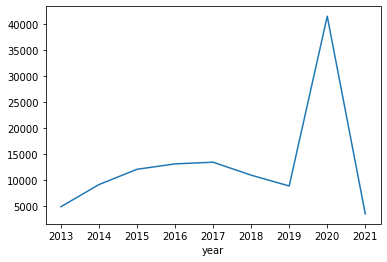

In [53]:
f.groupby('year').text.count().plot()

In [54]:
print(f.shape)
f = f[(f.text_reg != '')|(f.text_reg.isna()==False)]
f.to_csv('/is/texts/mfd/mfd_text_lower_tic_all_flag_all_dt_e_reg.csv', sep='|', index=False)
print(f.shape)
f.head()

(117381, 31)
(117381, 31)


,message,text,ticker,date,day,month,year,day_of_week,per,open,...,change_close_8,change_close_9,change_close_10,change_close_15,change_close_20,change_close_25,change_close_30,change_close_40,change_close_50,text_reg
0,"На заседании 4 февраля совет директоров ""Магни...","на заседании 4 февраля совет директоров ""магни...",mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000,на заседании февраля совет директоров магнита ...
1,магнит завтра 8100,магнит завтра 8100,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000,магнит завтра
2,Завтра народ начнет перекладываться из Магнита...,завтра народ начнет перекладываться из магнита...,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000,завтра народ начнет перекладываться из магнита...
3,на чертежаx посмотрел!без кукла Магнит не какой,на чертежаx посмотрел!без кукла магнит не какой,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000,на чертежа посмотрел без кукла магнит не какой
4,Вы человеку объективную картинку дайте!бумага ...,вы человеку объективную картинку дайте!бумага ...,mgnt,20140902.0,2,9,2014,1,D,8751.9,...,10.152053,9.622642,10.987791,8.213097,10.099889,11.642619,15.316315,20.943396,31.298557,вы человеку объективную картинку дайте бумага ...


In [2]:
f = pd.read_csv('/is/texts/mfd/mfd_text_lower_tic_all_flag_all_dt_e_reg.csv', sep='|')

In [3]:
f.head()

,message,text,ticker,date,day,month,year,day_of_week,per,open,...,change_close_8,change_close_9,change_close_10,change_close_15,change_close_20,change_close_25,change_close_30,change_close_40,change_close_50,text_reg
0,"На заседании 4 февраля совет директоров ""Магни...","на заседании 4 февраля совет директоров ""магни...",mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000,на заседании февраля совет директоров магнита ...
1,магнит завтра 8100,магнит завтра 8100,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000,магнит завтра
2,Завтра народ начнет перекладываться из Магнита...,завтра народ начнет перекладываться из магнита...,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000,завтра народ начнет перекладываться из магнита...
3,на чертежаx посмотрел!без кукла Магнит не какой,на чертежаx посмотрел!без кукла магнит не какой,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-8.333333,-9.285714,-8.767857,-10.476190,-15.871429,-7.738095,-6.190476,4.880952,4.750000,на чертежа посмотрел без кукла магнит не какой
4,Вы человеку объективную картинку дайте!бумага ...,вы человеку объективную картинку дайте!бумага ...,mgnt,20140902.0,2,9,2014,1,D,8751.9,...,10.152053,9.622642,10.987791,8.213097,10.099889,11.642619,15.316315,20.943396,31.298557,вы человеку объективную картинку дайте бумага ...


In [4]:
from pyaspeller import YandexSpeller
speller = YandexSpeller()
speller.spelled('сбербонк')

'сбербанк'

In [ ]:
f.text_reg = f.text_reg.astype(str)
f['text_reg_spell'] = None
for i in tqdm(range(f.shape[0]), position=0, leave=True):
    f['text_reg_spell'].iloc[i] = speller.spelled(f['text_reg'].iloc[i])
f.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Токенизация text_reg_spell

In [ ]:
tokens = []
l = f['text_reg_spell'].tolist()
print(len(l))
for i in tqdm(range(len(l)), position=0, leave=True):
    tokens.append(nltk.word_tokenize(l[i]))
print(len(tokens))

with open('/is/pkl/mfd_tokens_spell.pkl', 'wb') as tn:
    pickle.dump(tokens, tn)

### Добавляем стоп слова

In [80]:
stop_words = nltk.corpus.stopwords.words('russian')

In [81]:
ls = []
for i in stop_words:
    if 'да' not in i and 'не' not in i:
        ls.append(i.replace('ё', 'е'))
len(set(ls))

134

In [82]:
#https://www.bukvarix.com/bukvarix-stop-words.html
y = ['как', 'так', 'когда', 'где', 'куда', 'почему', 'зачем', 'сколько', 'откуда', 'только', 'еще', 'ещё', 'уже', 'да', 'нет', 'не', 'я', 'меня', 'мне', 'мной', 'мною', 'мой', 'мое', 'моё', 'моего', 'моему', 'моем', 'моя', 'мою', 'моей', 'моею', 'мои', 'моих', 'моим', 'моими', 'ты', 'тебя', 'тебе', 'тобой', 'тобою', 'он', 'оно', 'его', 'него', 'ему', 'нему', 'им', 'ним', 'нем', 'она', 'ее', 'её', 'нее', 'ей', 'ней', 'ею', 'нею', 'вы', 'вас', 'вам', 'вами', 'мы', 'нас', 'нам', 'нами', 'наш', 'наше', 'нашего', 'нашему', 'нашим', 'нашем', 'наша', 'нашу', 'нашей', 'нашею', 'наши', 'наших', 'нашим', 'нашими', 'они', 'их', 'них', 'им', 'ими', 'ними', 'кто', 'кого', 'кому', 'кем', 'ком', 'что', 'чего', 'чему', 'чем', 'этот', 'это', 'этого', 'этому', 'этим', 'этом', 'эта', 'эту', 'этой', 'этою', 'эти', 'этих', 'этим', 'этими', 'тот', 'то', 'того', 'тому', 'том', 'та', 'ту', 'той', 'те', 'тех', 'тем', 'теми', 'такой', 'такое', 'такого', 'такому', 'таком', 'такая', 'такую', 'такой', 'такою', 'такие', 'таких', 'таким', 'такими', 'свой', 'свое', 'своего', 'своему', 'своим', 'своем', 'своя', 'свою', 'своей', 'своею', 'свои', 'своих', 'своим', 'своими', 'который', 'которое', 'которого', 'которому', 'которым', 'котором', 'которая', 'которую', 'которой', 'которою', 'которые', 'которых', 'которым', 'которыми', 'сам', 'само', 'самого', 'самому', 'самим', 'самом', 'сама', 'саму', 'самой', 'сами', 'самих', 'самим', 'самими', 'себя', 'себе', 'собой', 'собою', 'один', 'одно', 'одного', 'одному', 'одним', 'одном', 'одна', 'одну', 'одной', 'одною', 'одни', 'одних', 'одним', 'одними', 'весь', 'всё', 'всего', 'всему', 'всем', 'вся', 'всю', 'всей', 'всею', 'все', 'всех', 'всем', 'всеми', 'твой', 'твоё', 'твое', 'твоего', 'твоему', 'твоим', 'твоем', 'твоём', 'твоя', 'твою', 'твоей', 'твоею', 'твои', 'твоих', 'твоим', 'твоими', 'ваш', 'ваше', 'вашего', 'вашему', 'вашим', 'вашем', 'ваша', 'вашу', 'вашей', 'вашей', 'вашею', 'ваши', 'ваших', 'вашим', 'вашими', 'какой', 'какое', 'какого', 'какому', 'каким', 'каком', 'какая', 'какую', 'какой', 'какие', 'каких', 'каким', 'какими', 'чей', 'чье', 'чьё', 'чьего', 'чьему', 'чьим', 'чьем', 'чья', 'чьей', 'чьею', 'чьи', 'чьих', 'чьим', 'чьими']


In [83]:
x = ['как', 'так', 'когда', 'только', 'еще', 'ещë', 'уже', 'я', 'меня', 'мне', 'мной', 'мною', 'мы', 'нас', 'нам', 'нами', 'ты', 'тебя', 'тебе', 'тобой', 'тобою', 'вы', 'вас', 'вам', 'вами', 'он', 'оно', 'его', 'него', 'ему', 'нему', 'им', 'ним', 'нем', 'нём', 'она', 'ее', 'еë', 'нее', 'неё', 'ей', 'ней', 'ею', 'нею', 'они', 'их', 'них', 'ими', 'ними', 'мой', 'мое', 'моë', 'моего', 'моему', 'моем', 'моëм', 'моя', 'мою', 'моей', 'моею', 'мои', 'моих', 'моим', 'моими', 'наш', 'наше', 'нашего', 'нашему', 'нашим', 'нашем', 'наша', 'нашу', 'нашей', 'нашею', 'наши', 'наших', 'нашими', 'кто', 'кого', 'кому', 'кем', 'ком', 'что', 'чего', 'чему', 'чем', 'этот', 'это', 'этого', 'этому', 'этим', 'этом', 'эта', 'эту', 'этой', 'этою', 'эти', 'этих', 'этими', 'тот', 'то', 'того', 'тому', 'том', 'та', 'ту', 'той', 'тою', 'те', 'тех', 'тем', 'теми', 'такой', 'такое', 'такого', 'такому', 'таком', 'такая', 'такую', 'такою', 'такие', 'таких', 'таким', 'такими', 'свой', 'свое', 'своё', 'своего', 'своему', 'своим', 'своем', 'своём', 'своя', 'свою', 'своей', 'своею', 'свои', 'своих', 'своими', 'который', 'которое', 'которого', 'которому', 'которым', 'котором', 'которая', 'которую', 'которой', 'которою', 'которые', 'которых', 'которыми', 'сам', 'себя', 'себе', 'собой', 'собою', 'один', 'одно', 'одного', 'одному', 'одним', 'одном', 'одна', 'одну', 'одной', 'одною', 'одни', 'одних', 'одними', 'весь', 'всë', 'всего', 'всему', 'всем', 'вся', 'всю', 'всей', 'всею', 'все', 'всех', 'всеми', 'кто-то', 'что-то', 'быть', 'был', 'была', 'было', 'были', 'буду', 'будем', 'будешь', 'будет', 'будут', 'будь', 'будьте', 'есть', 'мочь', 'могу', 'можем', 'можешь', 'можете', 'может', 'могут', 'мог', 'могла', 'могло', 'могли']

In [84]:
for i in y:
    if 'да' not in i and 'не' not in i:
        ls.append(i.replace('ё', 'е'))
len(set(ls))

306

In [85]:
for i in x:
    if 'да' not in i and 'не' not in i:
        ls.append(i.replace('ё', 'е'))
len(set(ls))

331

In [86]:
tickers = {
'gazp' : ['gazp', 'газпром',   'миллер', 'газик', 'нашевсе', 'северный', 'поток', 'южный', 'сибири', \
          'ru0007661625'],
    
'sber' : ['sber', 'сбер', 'греф', 'ru0009029540', 'сберушко', 'грефа', 'грефу'],
'vtb' : ['vtb', 'костин', 'втб', 'внешторгбанк', 'народное ipo', 'ru000A0JP5V6'],
'rosn':  ['rosn', 'роснефт', 'сечин', 'ru000a0j2q06', 'роснефть'],
'gmkn':  ['gmkn', 'норникел', 'nornickel', 'потанин', 'гмк', 'норк', 'интеррос', 'гамак', 'норникель'],
'moex':  ['московская биржа', 'мосбирж', 'moex', 'москухн', 'ru000a0jr4a1'],
'alrs':  ['алрос', 'alrosa', 'alrs', 'алмаз', 'бриллиант', 'нюрб', 'ru0007252813'],
'lkoh':  ['lkoh', 'luk', 'алекперов', 'лукойл', 'лучок', 'лучк', 'ru0009024277'],
'sngs':  ['сургут', 'sngs', 'surgutneftega', 'кубышка', 'сурик', 'снгс', 'ru0008926258'],
'tatn':  ['татнефт', 'tatneft', 'tatn', 'маганов', 'ru0009033591', 'татнефть'],
'yndx':  ['yndx', 'yandex', 'яндекс', 'волож'],
'aflt':  ['аэрофлот', 'aflt', 'добролет', 'аврор', 'российские', 'авиалинии', 'полубояринов'],
'fees':  ['фск еэс', 'fees', 'феес', 'федеральные', 'электросети', 'феск'],
'magn':  ['ммк', 'magn', 'магнитк', 'магнитогорск', 'магна'],
'mtss':  ['mts', 'мтс'],
'nvtk':  ['nvtk', 'новатэк', 'нова тэк', 'novatek', 'ямал спг', 'михельсон'],
'nlmk':  ['нлмк', 'nlmk', 'липецк', 'лисин', 'липк'],
'chmf':  ['северстал', 'chmf', 'severstal', 'севка', 'череповец', 'мордашов'],
'mgnt':  ['mgnt', 'магнит', 'magnit', 'марафон', 'групп', 'галицкий', 'тандер'],
'plzl':  ['plzl', 'polyus', 'полюс', 'polyusgold', 'сухой', 'лог'],
'qiwi':  ['qiwi', 'киви'],
'rasp':  ['rasp', 'распад'],
'lsrg':  ['лср', 'lsr', 'элэсэр'],
'mtlr':  ['мечел', 'mtlr', 'mechel', 'ru000a0jpv70', 'мечело'],
'phor':  ['фосагр', 'phor', 'phosagr', 'фосфат', 'dap'],
'rtkm':  ['rtkm', 'rostelecom', 'ростел', 'tele2', 'ртк', 'рткм', 'осеевский'],
'hydr':  ['русгидр', 'hydr', 'rushydr', 'гидра', 'ru000a0jpkh7', 'русгидра', 'русгидро'],
'afks':  ['афк', 'afks', 'afk sistem', 'ozon', 'евтушенков', 'система'],
'trmk':  ['тмк', 'трубная', 'trmk', 'tmk', 'трмк'],
'upro':  ['юнипро', 'upro', 'unip', 'эон', 'россия', 'березовская', 'грэс'],
'akrn':  ['акрон', 'akrn', 'akron', 'азотные', 'удобрения'],
'pikk':  ['пик', 'pik', 'мортон'],
'lnta':  ['лент', 'lent', 'lnta', 'tpg capital'],
'msng':  ['мосэнерг', 'msng', 'mosenerg', 'мося'],
'tgka':  ['тгк1', 'тгк-1', 'тгк 1', 'tgka', 'tgk-1', 'tgk1', 'tgk 1'],
'rual':  ['русал', 'rusal', 'rual', 'русский алюминий', 'краз', 'дерипаск', 'дерипаска'],
'trnf':  ['транснефт', 'trnf', 'нефтепровод дружба'],
'sibn':  ['газпромнефт', 'sibn', 'gazpromneft', 'sibneft', 'сибнефт', 'газнефт'],
'nmtp':  ['нмтп', 'nmtp', 'новороссийск', 'новопорт'],
'tanl':  ['tanl', 'tantal', 'тант'],
'iskj':  ['искч', 'институт стволовых клеток', 'стволовые клетки', 'стволовых клеток', 'iskj'],
'yakg':  ['ятэк', 'yakg', 'yakutsk fue', 'якутская топл', 'ru0007796819'],
'gtlc':  ['gtl', 'джитиэл', 'гтл'],
'gche':  ['черкизов', 'cherkizov', 'che'],
'rolo':  ['русолов', 'rolo', 'rusolov', 'ролово'],
'svav':  ['соллерс', 'svav', 'sollers', 'северстальавт', 'уаз'],
'arsa':  ['арсагер', 'ук арса', 'arsa', 'arsager'],
'krkn':  ['саратовский нпз', 'снпз', 'krkn', 'сарнпз'],
'selg':  ['селигдар', 'seligdar', 'selg'],
'prfn':  ['чзпсн', 'профнастил', 'настил', 'prfn'],
'gaza':  ['gaza', 'завод', 'газ', 'авто', 'газель', 'горьковский'],
'kbtk':  ['kbtk', 'кбтк', 'кузбас', 'даэния', 'холдинг'],
'nknc':  ['nknc', 'нижнекамск', 'нкнх', 'нефтехим'],
'aptk':  ['aptk', 'аптек', '36 и 6', '36.6'],
'amez':  ['amez', 'ашинский', 'аша', 'amet', 'амез', 'амет'],
'dasb':  ['dasb', 'даг'],
'irkt':  ['иркут', 'irkt', 'сухой', 'суперджет', 'sukhoi', 'ssj'],
'lsng':  ['ленэнерг', 'lsng', 'ленк', 'петербургские', 'электросети', 'ленэнерго'],
'rlmn':  ['ролл', 'ролман', 'rlmn', 'роля'],
'obuv':  ['обувь росси', 'obuv', 'westfalika', 'обувьрус'],
'abrd':  ['абрау', 'дюрсо', 'abrd', 'abrau', 'durso', 'русский', 'винный', 'дом', 'борис', 'титов', 'ru000a0js5t7'],
'agro':  ['agro', 'русагро', 'us7496552057'],
'albk':  ['бест эффортс', 'albk', 'best efforts', 'алор', 'банкбестэфб', 'ru000a0js2m9'],
'alnu':  ['alnu', 'nyurba', 'алроса', 'нюрба', 'якуталмаз', 'ru000a0jp468'],
'aqua':  ['аквакультураaqua', 'aquacultur', 'русаква', 'русское', 'море', 'ru000a0jqts3'],
'assb':  ['астрэнсб', 'assb', 'astrakhan', 'аэск', 'астраханэнергосбыт', 'ru000a0d8mm8'],
'avan':  ['avangard', 'авангард', 'ru000a0dm7b3'],
'bane':  ['башнефт', 'bane', 'bashneft', 'ru0007976957', 'башнефть'],
'belu':  ['белуг', 'belu', 'belug', 'ru000a0hl5m1', 'белуга'],
'bisv':  ['bisv', 'bashinformsvyaz', 'bashtel', 'ru0009059216'],
'blng':  ['белон', 'blng', 'belon', 'ru000a0j2qg8'],
'brzl':  ['бурзолот', 'brzl', 'buryatzolot', 'бурятзолот', 'ru0009288658'],
'bspb':  ['бсп', 'bspb', 'bank st petersburg', 'банк', 'санкт', 'петербург', 'ленбанк', 'ru0009100945'],
'cbom':  ['мкб', 'cbom', 'credit bank of moscow', 'московский', 'кредитный', 'ru000a0jug31'],
'chep':  ['чтпз', 'chep', 'chelyabinsk pipe plant', 'chelpipe', 'chtpz', 'челябинский', 'трубопрокатн', 'ru0009066807'],
'chgz':  ['рн-запсиб', 'запсиб', 'chgz', 'rn', 'western', 'siberia', 'западная', 'сибирь', 'буй', 'ru0009082291'],
'chkz':  ['чкпз', 'chkz', 'chkpz', 'челябинский кузнечно-прессовый заво', 'chelyabinsk forge & press plant', \
          'гартунг', 'ru000a0jnst0'],
'cntl':  ['телеграф', 'cntl', 'telegraf', 'ru0007665147'],
'diod':  ['заводдиод', 'diod', 'диод', 'ru000a0jqwc1'],
'dsky':  ['dsky', 'detskiy mir', 'детский', 'ru000a0jsq90'],
'dvec':  ['дэк', 'dvec', 'feec', 'far-eastern energy', 'дальневосточная энергетическая компания', 'ru000a0jp2w1'],
'dzrd':  ['донскзр', 'dzrd', 'donskoy factory of radiocomponents', 'донской завод радиодеталей', \
          'donskoy zavod radiodetaley', 'ru000a0jqw11'],
'eelt':  ['евроэлтех', 'eelt', 'european eltech', 'европэлектротехника', 'европейская электротехника', 'каленков', \
          'ru000a0jww54'],
'eltz':  ['eltz', 'electrozinc', 'электроцинк', 'ru000a0b66v1'],
'enpg':  ['эн+', 'enpg', 'en plus', 'en+', 'ru000a100k72'],
'enru':  ['энелрос', 'enru', 'enel', 'энел', 'ru000a0f5un3'],
'etln':  ['etln', 'etalon', 'эталон', 'us29760g1031'],
'fesh':  ['двмп', 'fesh', 'fesco', 'дв морское пароходство', 'far-eastern shipping co plc', 'ru0008992318'],
'five':  ['five', 'x5', 'пятерочк', 'шехтерман', 'перекрест', 'карусел', 'us98387e2054'],
'flot':  ['совкомфлот', 'flot', 'sovcomflot', 'современный коммерческий флот', 'ru000a0jxnu8'],
'gazc':  ['газкон', 'gazc', 'ru000a0jqg86'],
'gazs':  ['газсервис', 'газ-сервис', 'gazs', 'gaz-service', 'ru000a0jqg78'],
'gazt':  ['газтек', 'газ-тек', 'gazt', 'gaz-tek', 'ru000a0js199'],
'gema':  ['ммцб', 'gema', 'mmtsb', 'biomaterials processing and cryostorage', 'гема', \
          'обработки и криохранения биоматериалов', 'ru000a100gc7'],
'gltr':  ['gltr', 'глобалтранс', 'globaltrans', 'us37949e2046'],
'gtrk':  ['гтм', 'gtrk', 'globaltruck', 'глобалтрак', 'gtm', 'ru000a0zyd22'],
'gtss':  ['геотек', 'gtss', 'geotech', 'сейсморазведка', 'ru000a0jq7u3'],
'hals':  ['галс', 'hals', 'пучков', 'ru000a0jnp96'],
'himc':  ['химпром', 'himc', 'khimprom', 'ru0009098990'],
'igst':  ['ижстал', 'igst', 'izhstal', 'козеннов', 'ru0002155292'],
'irao':  ['интеррао', 'irao', 'интер рао', 'inter rao', 'борис ковальчук', 'ru000a0jpnm1', 'рао', 'интер'],
'irgz':  ['иркэнерго', 'irgz', 'irkutskenergo', 'иркутскэнерго', 'ru0008960828'],
'jnos':  ['славн-янос', 'jnos', 'slavneft yaroslavnefteorgsintez', 'славнефт', 'ярославнефт', 'ru0009100895'],
'kazt':  ['куйбазот', 'kazt', 'kuibyshevazot', 'куйбышевазот', 'ru000a0b9bv2'],
'kbsb':  ['тнсэкубань', 'kbsb', 'tns energo kuban', 'энерго кубань', 'кубанская энергосбытовая компания', 'ru000a0jnj11'],
'kche':  ['камчатскэ', 'kche', 'kamchatskenergo', 'ru0006753498'],
'kgkc':  ['кургангк', 'kgkc', 'kurgan generation', 'курганская генер', 'кгк', 'ru000a0jp120'],
'klsb':  ['калужскск', 'klsb', 'kaluga power', 'калужская сбыт', 'ru000a0dkzk3'],
'kmaz':  ['камаз', 'kmaz', 'kamaz', 'ru0008959580'],
'kmez':  ['кмз', 'kmez', 'kovrov', 'ковровск', 'ru0006753613'],
'kmtz':  ['косогмз', 'kmtz', 'kosaya gora', 'косогорск', 'kosogorski', 'ru000a0hf1l0'],
'kogk':  ['коршгок', 'kogk', 'korshynov', 'коршуновск', 'ru0002155359'],
'krko':  ['ткзкк', 'krko', 'krasny kotelshchik', 'красный котельщик', 'ru0009098123'],
'krot':  ['красокт', 'krot', 'крот', 'krasnyj octyabr', 'красный октябрь', 'krasny oktyabr', 'ru0008913850'],
'krsb':  ['красэсб', 'krsb', 'krasnoyarskenergo', 'красноярскэнерго', 'ru000a0hmly1'],
'ksgr':  ['кокс', 'ksgr', 'koks', 'ru000a0ernt3'],
'ktsb':  ['ксб', 'ktsb', 'kostroma', 'костромск', ' kostromskaya sbyto', 'костромская сбытовая компания', 'ru000a0d8lw9'],
'kube':  ['кубанэн', 'kube', 'kubanenergo', 'кубаньэнерго', 'kuban power', 'rosseti kuban', 'ru0009046767'],
'kunf':  ['кузоцм', 'kunf', 'kuzocm', 'каменск-уральский', 'каменск уральский', 'ru000a0jpge2'],
'kuzb':  ['кузнецкий банк', 'kuzb', 'bank kuznetskiy', 'kuznetskiy bank', 'банк кузнец', 'ru000a0jsq66'],
'kzms':  ['кзмс', 'kzms', ' krasnokamsk metal', 'краснокамский завод', 'ru000a0jnhk2'],
'kzos':  ['органический синтез', 'kzos', 'оргсинтез', 'organicheskiy sintez', 'ru0009089825'],
'life':  ['фармсинтез', 'life', 'pharmsynt', 'ru000a0jr514'],
'lnzl':  ['лензолото', 'lnzl', 'lenzoloto', 'ленское золотодобывающ', 'ru000a0jp1n2'],
'lpsb':  ['лэск', 'lpsb', 'липецкая энерго', 'lipetsk power', 'lipetsk energ', 'ru000a0d8mr7'],
'mage':  ['магадэн', 'mage', 'magadanen', 'магаданэн', 'ru0006758919'],
'mail':  ['mail', 'mail.ru', 'mail', 'мэйл.ру', 'мэйл ру', 'добродеев', 'us5603172082'],
'mfgs':  ['мегион', 'mfgs', 'megionneftegas', 'ru0009011126'],
'mgnz':  ['смз', 'mgnz', 'smz', 'соликамский магн', 'ru0009100911'],
'mgts':  ['мгтс', 'mgts', 'moscow city tele', 'московская городская телефонная', 'moskovskaya gorodskaya tele',\
          'ru0009036461'],
'misb':  ['тнсэнмарэ', 'тнс', 'энерго', 'мари', 'ru000a0d8k33'],
'mobb':  ['mobb', 'moskovskii oblastnoi bank', 'московский', 'областной', 'мособлбанк', 'ru000a0js7v9'],
'mori':  ['морион', 'mori', 'morion', 'телекоммуникационное', 'оборудование', 'ru0009092431'],
'mrkc':  ['мрск центр', 'mrkc', 'ru000a0jppl8'],
'mrkk':  ['россети ск', 'mrkk', 'rosseti north caucasus', 'мрск северного кавказа', 'ru000a0jppq7'],
'mrkp':  ['мрск цп', 'mrkp', 'мрск центра и приволжья', 'ru000a0jpn96'],
'mrks':  ['mrks', 'rosseti siberia', 'россети сибирь', 'mrsk sibiri', 'мрск сибири', 'ru000a0jppf0'],
'mrku':  ['мрск ур', 'mrku', 'idgc of ural', 'ru000a0jppt1'],
'mrkv':  ['mrkv', 'rosseti volg', 'россети волг', 'мрск волг', 'ru000a0jppn4'],
'mrky':  ['россюг', 'mrky', 'rosseti south', 'россети юг', 'мрск юг', 'ru000a0jppg8'],
'mrkz':  ['мрск сз', 'mrkz', 'мрск северо-запад', 'mrsk severo zapad', 'ru000a0jppb9'],
'mrsb':  ['мордэнсб', 'mrsb', 'mordovia energ', 'мордовская энерг', 'ru000a0d9aj7'],
'msrs':  ['msrs', 'rosseti mosc', 'россети моск', 'московская объедин', 'ru000a0et7y7'],
'mstt':  ['мостотрест', 'mstt', 'mostotrest', 'ru0009177331'],
'mvid':  ['мвидео', 'mvid', 'м.видео', 'м видео', 'эльдорадо', 'изосимов', 'ru000a0jpga0'],
'nauk':  ['нпонаука', 'nauk', 'нпо наука', 'ru000a0jrpx9'],
'nfaz':  ['нефтекамск', 'nfaz', 'nefaz', 'ru0009115604'],
'nkhp':  ['нкхп', 'nkhp', 'novorossiysk grain', 'novorossiyskiy kombi', 'новороссийский комбин', 'ru000a0blwd7'],
'nksh':  ['нижкамшина', 'nksh', 'nizhnekamskshina', 'нижнекамскшина', 'ru0009100515'],
'nnsb':  ['тнсэннн', 'nnsb', 'tns energo n', 'тнс энерго н', 'ru000a0et5a1'],
'npof':  ['физик', 'npof', 'fizik', 'ru000a0jq5x1'],
'nsvz':  ['наукасвяз', 'nsvz', 'nauka-svyaz', 'nauka-tele', 'наука-связ', 'наука связ', 'ru000a0jqlb6'],
'ogkb':  ['огк-2', 'огк2', 'ogkb', 'ogk-2', 'семиколенов', 'ru000a0jng55'],
'paza':  ['павлавт', 'paza', 'pavlovo', 'павловский авт', 'pavlovskiy avt', 'паз', 'ru0009083240'],
'pmsb':  ['пермьэнсб', 'pmsb', 'perm energ', 'пермэнерг', 'permskaya energ', 'пермская энерг', 'ru000a0et123'],
'prmb':  ['prmb', 'primorie bank', 'приморье банк', 'банк приморье', 'ru000a0dpnq5'],
'prtk':  ['протек', 'prtk', 'protek', 'ru000a0jqu47'],
'rbcm':  ['рбк', 'rbcm', 'rbk', 'rbc', 'ru000a0jr6a6'],
'rdrb':  ['рдбанк', 'rdrb', 'rosdorbank', 'российскийдор', 'российский дор', 'ru000a0ju6q7'],
'rgss':  ['ргс', 'rgs', 'rosgosstra', 'росгосстра', 'гальперин', 'ru0008010855'],
'rkke':  ['энергияркк', 'rkke', 'spc energia', 'ркк энергия', 'ru0009095939'],
'rnft':  ['rnft', 'russneft', 'русснефт', 'ru000a0jse60'],
'rosb':  ['росбанк', 'rosb', 'rosbank', 'ru000a0hhk26'],
'rsti':  ['россет', 'rsti', 'российские сети', 'ru000a0jpvj0', 'россеть', 'россети'],
'rtgz':  ['rtgz', 'rostovoblgaz', 'ростовоблгаз', 'ru000a0jpg04'],
'rtsb':  ['rtsb', 'tns energo rost', 'тнс энерго рост', 'ru000a0d8pb4'],
'rugr':  ['русгрэйн', 'ругрэйн', 'rugr', 'rusgrain', 'русское зерн', 'ru000a0jpnp4'],
'rusi':  ['икрусс', 'rusi', 'руссинвест', 'рус инвест', 'ru000a0jq9w5'],
'rusp':  ['русполимет', 'rusp', 'ruspol', 'ru000a0jnh21'],
'rzsb':  ['rzsb', 'ryazan energ', 'рязанская энерг', 'рязаньэнерго', 'ru000a0d9af5'],
'sago':  ['sago', 'samaraen', 'самараэнерго', 'самарэнерго', 'ru0009098255'],
'sare':  ['sare', 'saratoven', 'саратовэнерго', 'ru0009100754'],
'sfin':  ['сафмар', 'sfin', 'safmar', 'европлан', 'ru000a0jvw89'],
'slen':  ['сахэнер', 'slen', 'sakhalinen', 'сахалинэн', 'ru0009280465'],
'smlt':  ['самолет', 'smlt', 'samolet', 'ru000a0zzg02'],
'stsb':  ['stsb', 'stavropolen', 'ставрополэн', 'ставропольэн', 'ru000a0et1w4'],
'tasb':  ['tasb', 'tambov en', 'тамбовская эн', 'тамбовэнерго', 'ru000a0d8ng8'],
'tcsg':  ['tcs', 'tinkof', 'тисиэс', 'тинек', 'тинькофф', 'us87238u2033', 'тиньковы', \
          'тинькоф', 'тинькова', 'тинькову', 'тиньков', 'тиньковский'],
'tgkb':  ['тгк 2', 'тгк-2', 'тгк2', 'tgkb', 'tgc-2', 'tgc2', 'tgc 2', 'ru000a0jngs7'],
'tgkd':  ['квадр', 'tgkd', 'quadra', 'ru000a0jnmz0'],
'tgkn':  ['тгк-14', 'тгк14', 'тгк 14', 'tgkn', 'tgk-14', 'tgk14', 'tgk 14', 'ru000a0h1es3'],
'tnse':  ['тнсэнерг', 'tns', 'tns energ', 'тнс энерг', 'ru000a0jucq5'],
'tors':  ['трк', 'tors', 'tomsk distribution', 'томская распред', 'ru000a0etzf2'],
'trcn':  ['транск', 'trcn', 'transcontainer', 'трансконтейнер', 'транс контейнер', 'ru000a0jprx9'],
'trfm':  ['трансф', 'trfm', 'transfin', 'трансфин', 'ru000a0jugp8'],
'ttlk':  ['таттел', 'ttlk', 'tattel', 'ru000a0hm5c1'],
'tuza':  ['тза', 'tuza', 'tuimazinsk', 'туймазинск', 'teuza', 'ru000a0hl7a2'],
'ucss':  ['окс', 'ucss', 'united credit', 'объединенные кредитн', 'ru000a0jtqk0'],
'ukuz':  ['южкузб', 'ukuz', 'southern kuzb', 'южный куз', 'юж куз', 'ru0005294775'],
'unac':  ['авиасткао', 'unac', 'united aircraft', 'объединенная авиа', 'ru000a0jplz7'],
'unkl':  ['юунк', 'unkl', 'southern ural', 'южно-уральский ник', 'ru0004887991'],
'urka':  ['урка', 'urka', 'uralka', 'уралка'],
'urkz':  ['уркузн', 'urkz', 'urals stampings', 'уралкуз', 'уральская кузниц', 'ru000a0jpfy2'],
'usbn':  ['уралсиб', 'usbn', 'uralsib', 'урсиб', 'ru0006929536'],
'utar':  ['ютэйр', 'utar', 'utair', 'ru0007661385'],
'uwgn':  ['овк', 'uwgn', 'united wagon', 'нпк овк', 'ru000a0jvbt9'],
'vgsb':  ['vgsb', 'volgograden', 'волгоградэн', 'volgograd en', 'ru000a0d8l73'],
'vjgz':  ['варьеган', 'vjgz', 'varyogan', 'varyegan', 'ru0009046460'],
'vlhz':  ['вхз', 'vlhz', 'vladimir chem', 'владимирский хим', 'ru0007984761'],
'vrsb':  ['vrsb', 'tns energo voronez', 'тнс энерго воронеж', 'ru000a0dpg67'],
'vsmo':  ['всмпо-авсм', 'vsmo', 'vsmpo-avisma', 'ависма', 'ru0009100291'],
'vsyd':  ['выбсуд', 'vsyd', 'vyborg ship', 'vyborgskiy sud', 'выборгский суд', 'ru0006334372'],
'vzrz':  ['возрожд', 'vzrz', 'vozrozhd', 'ru0009084214'],
'wtcm':  ['цмт', 'wtcm', 'world trade cen', 'центр международной торговли', 'ru0008137070'],
'yken':  ['якутскэнерг', 'yken', 'yakutskenerg', 'ru0009257075'],
'yrsb':  ['yrsb', 'tns energo yarosavl', 'тнс энерго ярославл', 'ru000a0d8760'],
'zill':  ['зил', 'zill', 'likhach', 'лихачев', 'ru0009086193'],
'zvez':  ['звезд', 'zvez', 'zvezd', 'ru0009091300']
}

In [87]:
def clear_text(x):
    return re.sub('\s+', '', re.sub(' +',u' ', re.sub(u'[^а-я ]',u' ', x.lower())))

tickers_split = list()
for i in tickers:
    for j in tickers[i]:
        x = j.split()
        for y in x:
            z = clear_text(y)
            if z != '':
                tickers_split.append(z)

In [89]:
print(len(set(ls)))
for i in tickers_split:
    ls.append(i)
print(len(set(ls)))

331
869
869


In [79]:
names = ['Абрамович', 'Авен', 'Алекперов', 'Белозеров', 'Богданов', 'Вексельберг', 'Венедиктов', 'Волож', 'Греф', 'Дерипаска', 'Дуров', 'Евтушенков', 'Задорнов', 'Иванов', 'Ивлев', 'Касперский', 'Конов', 'Костин', 'Линник', 'Лисин', 'Лихачев', 'Мазепин', 'Махмудов', 'Мельниченко', 'Миллер', 'Михайлов', 'Михельсон', 'Мордашов', 'Пономаренко', 'Потанин', 'Рашников', 'Ротенберг', 'Сечин', 'Симоньян', 'Слюсарь', 'Стрешинский', 'Тимченко', 'Тиньков', 'Тынкован', 'Усманов', 'Фридман', 'Фролов', 'Хан', 'Чемезов', 'Чубайс', 'Шувалов', 'Добродеев', 'Бобровников', 'Соловьева', 'Щербаков', 'Абрамян', 'Генс', 'Жуков', 'Романенко', 'Шушкин', 'Филатов', 'Авдеев', 'Барулин', 'Джеба', 'Дубин', 'Лаптаев', 'Ляпунов', 'Оселедько', 'Рыжиков', 'Спиридонов', 'Хасьянова', 'Верхошинский', 'Руденко', 'Монин', 'Зауэрс', 'Поляков', 'Андресов', 'Полунин', 'Алексеев', 'Пешнев-Подольский*', 'Чижевский', 'Шамолин', 'Хряпов', 'Никипелов', 'Липа', 'Маврин', 'Горбунов', 'Воробьев**', 'Колмыков', 'Муругов', 'Молибог', 'Кочетков', 'Бергер', 'Доронов', 'Вайнштейн', 'Слащева', 'Герасимов', 'Веселкова', 'Паскина', 'Абашидзе', 'Благодыренко', 'Болтянский', 'Голубева', 'Емельянов', 'Куликова', 'Лавров', 'Новиков', 'Саркисов', 'Тадевосян', 'Толстоган', 'Тюлин', 'Хрипунова', 'Яременко', 'Никитин', 'Сафин', 'Шевелев', 'Федоришин', 'Шиляев', 'Еремина', 'Несис', 'Грачев', 'Коржов', 'Куземченко', 'Корытько', 'Зингман', 'Чирахов', 'Илиопуло', 'Ходоровский', 'Бакальчук', 'Гришаков', 'Шульгин', 'Гюванч', 'Бардинцева', 'Правдивый', 'Рогозов', 'Шулейко', 'Аракелян', 'Миндубаева', 'Сергеев', 'Федчин', 'Чеканов', 'Старрок', 'Раммохан', 'Кузьмина', 'Ершов', 'Родионов', 'Шпаков', 'Леманн', 'Марсий', 'Соломон', 'Федоров', 'Максимовская', 'Фадеева', 'Баранников', 'Шапигузов', 'Дмитриева', 'Козлова', 'Терехов', 'Виноградов', 'Бекренев', 'Борисов', 'Глазова', 'Горохова', 'Долякова', 'Донских', 'Змеющенко', 'Казанский', 'Кантор', 'Кнауль', 'Коулберн', 'Кремер', 'Лапушкина', 'Лащевский', 'Литинецкая', 'Маслов', 'Минченко', 'Оганджанян', 'Писарский', 'Розин', 'Рябокобылко', 'Сидоренко', 'Тарнопольская', 'Топильская', 'Тышковский', 'Хлюстов', 'Шнайдер', 'Корня', 'Вермишян', 'Эмдин', 'Васильев', 'Чуб', 'Кравцов', 'Вольпе', 'Горбунова', 'Басов', 'Недужко', 'Мак', 'Клюка', 'Гидирим', 'Шаронов', 'Бабаев', 'Брусилова', 'Климишин', 'Полякова', 'Прянишников', 'Курцер', 'Ордовский-Танаевский', 'Швецов', 'Обыденнова', 'Пехова', 'Скворцов', 'Гальперин', 'Йордан', 'Тихонова', 'Тарновский', 'Раковщик', 'Поселенов', 'Голубицкий', 'Молчанов', 'Щербина', 'Адамов', 'Становова', 'Лунтовский', 'Елистратов', 'Марков', 'Аквардар', 'Шехтерман', 'Дюннинг', 'Кришнев', 'Дефассье', 'Соколова', 'Шумахер', 'Курбатов', 'Смыков', 'Гончаров', 'Давыдова', 'Карпова', 'Кузин', 'Филиппов', 'Василенко', 'Воронович', 'Бисембаева', 'Сахаров', 'Калетин', 'Морозов', 'Монж', 'Патруйярд', 'Музяев', 'Нестеренко', 'Клыков', 'Христенко', 'Флоренцано', 'Литвинова', 'Бучнева', 'Никулина', 'Нифантьев', 'Погребинский', 'Малиновский', 'Потапов', 'Денисов', 'Кривошеева', 'Бугаенко', 'Зайцев', 'Протопопов', 'Ивантер', 'Соколов', 'Спиров', 'Агаджанов', 'Бусаров', 'Вышлова', 'Горчаковская', 'Елинсон', 'Менжинский', 'Михасенко', 'Сагдиев', 'Судариков', 'Нечаев', 'Гурьев', 'Осипов', 'Момцемлидзе', 'Куницкий', 'Рёриг', 'Рашевский', 'Вагнер', 'Ковальчук', 'Шароватов', 'Роман', 'Петр', 'Вагит', 'Олег', 'Владимир', 'Виктор', 'Алексей', 'Аркадий', 'Герман', 'Павел', 'Михаил', 'Сергей', 'Александр', 'Евгений', 'Дмитрий', 'Андрей', 'Искандар', 'Леонид', 'Игорь', 'Маргарита', 'Юрий', 'Иван', 'Геннадий', 'Алишер', 'Анатолий', 'Борис', 'Юлия', 'Рафаэль', 'Филипп', 'Ирис', 'Гульнара', 'Илья', 'Тимофей', 'Кирилл', 'Вячеслав', 'Николай', 'Тимур', 'Юлиана', 'Екатерина', 'Ольга', 'Кахабер', 'Валентина', 'Григорий', 'Руслан', 'Максим', 'Марина', 'Денис', 'Наталья', 'Виталий', 'Вадим', 'Татьяна', 'Донмез', 'Яна', 'Даниил', 'Арам', 'Антон', 'Нил', 'Ашок', 'Регина', 'Ларс', 'Валерий', 'Марианна', 'Елена', 'Нина', 'Константин', 'Лилия', 'Мария', 'Андреас', 'Иан', 'Алена', 'Марк', 'Дарья', 'Ульф', 'Геворк', 'Фарлан', 'Патрик', 'Раиса', 'Бланко', 'Инна', 'Майя', 'Вениамин', 'Авни', 'Ян', 'Лоран', 'Алла', 'Мартин', 'Владислав', 'Тихон', 'Анастасия', 'Алина', 'Оксана', 'Эрик', 'Манлио', 'Ирина', 'Анна', 'Лариса', 'Асхат', 'Кристоф', 'Агафья', 'Аглая', 'Агния', 'Агриппина', 'Акулина', 'Алевтина', 'Александра', 'Ангелина', 'Анжела', 'Анжелика ', 'Анна ', 'Антонина', 'Анфиса ', 'Валерия', 'Варвара', 'Василиса', 'Вера ', 'Вероника', 'Виктория ', 'Галина', 'Глафира', 'Гликерия', 'Дана ', 'Евгения', 'Евдокия', 'Евлалия', 'Евлампия', 'Евпраксия', 'Евфросиния', 'Елизавета', 'Епистима', 'Ермиония', 'Жанна', 'Зинаида', 'Злата', 'Зоя', 'Инга ', 'Инесса', 'Инна ', 'Иоанна', 'Ираида', 'Ия ', 'Капитолина', 'Карина', 'Каролина ', 'Кира', 'Клавдия', 'Ксения', 'Лада ', 'Лариса ', 'Лидия ', 'Лилия ', 'Любовь ', 'Людмила ', 'Мария ', 'Марфа', 'Матрёна', 'Милица', 'Мирослава', 'Надежда ', 'Нонна', 'Октябрина', 'Олимпиада ', 'Павлина', 'Пелагея', 'Пинна ', 'Полина', 'Прасковья', 'Рада ', 'Римма ', 'Светлана', 'Серафима', 'Снежана', 'София ', 'Таисия', 'Тамара ', 'Улита', 'Ульяна', 'Урсула ', 'Фаина', 'Феврония', 'Фёкла', 'Феодора ', 'Целестина', 'Яна ', 'Ярослава', 'Смирнов', 'Кузнецов', 'Попов', 'Лебедев', 'Козлов', 'Петров', 'Волков', 'Соловьёв', 'Павлов', 'Семёнов', 'Голубев', 'Воробьёв', 'Фёдоров', 'Беляев', 'Тарасов', 'Белов', 'Комаров', 'Орлов', 'Киселёв', 'Макаров', 'Андреев', 'Ковалёв', 'Ильин', 'Гусев', 'Титов', 'Кузьмин', 'Кудрявцев', 'Баранов', 'Куликов', 'Степанов', 'Яковлев', 'Сорокин', 'Романов', 'Захаров', 'Королёв', 'Пономарёв', 'Григорьев', 'Лазарев', 'Медведев', 'Соболев', 'Рябов', 'Цветков', 'Данилов', 'Журавлёв', 'Николаев', 'Крылов', 'Максимов', 'Сидоров', 'Белоусов', 'Федотов', 'Дорофеев', 'Егоров', 'Матвеев', 'Бобров', 'Дмитриев', 'Калинин', 'Анисимов', 'Петухов', 'Антонов', 'Тимофеев', 'Никифоров', 'Веселов', 'Большаков', 'Суханов', 'Миронов', 'Ширяев', 'Александров', 'Коновалов', 'Шестаков', 'Казаков', 'Ефимов', 'Громов', 'Фомин', 'Давыдов', 'Мельников', 'Блинов', 'Колесников', 'Карпов', 'Афанасьев', 'Власов', 'Исаков', 'Тихонов', 'Аксёнов', 'Гаврилов', 'Котов', 'Кудряшов', 'Быков', 'Зуев', 'Третьяков', 'Савельев', 'Панов', 'Рыбаков', 'Суворов', 'Абрамов', 'Воронов', 'Мухин', 'Архипов', 'Трофимов', 'Мартынов', 'Горшков', 'Чернов', 'Овчинников', 'Селезнёв', 'Панфилов', 'Копылов', 'Михеев', 'Галкин', 'Назаров', 'Лобанов', 'Лукин', 'Беляков', 'Некрасов', 'Хохлов', 'Жданов', 'Наумов', 'Шилов', 'Воронцов', 'Ермаков', 'Дроздов', 'Игнатьев', 'Савин', 'Логинов', 'Сафонов', 'Капустин', 'Кириллов', 'Моисеев', 'Елисеев', 'Кошелев', 'Горбачёв', 'Орехов', 'Ефремов', 'Исаев', 'Евдокимов', 'Калашников', 'Кабанов', 'Носков', 'Юдин', 'Кулагин', 'Лапин', 'Прохоров', 'Нестеров', 'Харитонов', 'Агафонов', 'Муравьёв', 'Ларионов', 'Федосеев', 'Зимин', 'Пахомов', 'Шубин', 'Игнатов', 'Крюков', 'Рогов', 'Кулаков', 'Терентьев', 'Владимиров', 'Артемьев', 'Зиновьев', 'Гришин', 'Кононов', 'Дементьев', 'Ситников', 'Симонов', 'Мишин', 'Фадеев', 'Комиссаров', 'Мамонтов', 'Носов', 'Гуляев', 'Шаров', 'Устинов', 'Вишняков', 'Евсеев', 'Лаврентьев', 'Брагин', 'Константинов', 'Корнилов', 'Зыков', 'Бирюков', 'Шарапов', 'Никонов', 'Щукин', 'Дьячков', 'Одинцов', 'Сазонов', 'Якушев', 'Красильников', 'Гордеев', 'Самойлов', 'Князев', 'Беспалов', 'Уваров', 'Шашков', 'Бобылёв', 'Доронин', 'Белозёров', 'Рожков', 'Самсонов', 'Мясников', 'Лихачёв', 'Буров', 'Сысоев', 'Фомичёв', 'Русаков', 'Стрелков', 'Гущин', 'Тетерин', 'Колобов', 'Субботин', 'Фокин', 'Блохин', 'Селиверстов', 'Пестов', 'Кондратьев', 'Силин', 'Меркушев', 'Лыткин', 'Туров', 'Авдей', 'Авксентий', 'Агафон', 'Акакий', 'Альберт', 'Альвиан', 'Аникита', 'Антонин', 'Анфим', 'Аристарх', 'Арсений', 'Артём', 'Артемий', 'Артур', 'Архипп', 'Афанасий', 'Богдан', 'Вавила', 'Валентин', 'Валерьян', 'Варлам', 'Варсонофий', 'Варфоломей ', 'Василий', 'Венедикт', 'Вениамин ', 'Викентий ', 'Виктор ', 'Виссарион', 'Владимир ', 'Владлен', 'Влас', 'Всеволод', 'Гавриил', 'Галактион', 'Геласий', 'Георгий', 'Герасим', 'Германн', 'Глеб', 'Гордей', 'Данакт', 'Даниил ', 'Демид ', 'Демьян', 'Добрыня', 'Донат', 'Дорофей', 'Евграф', 'Евдоким', 'Евсей', 'Евстафий', 'Егор', 'Емельян', 'Еремей', 'Ермолай', 'Ерофей', 'Ефим', 'Ефрем', 'Ждан', 'Зиновий', 'Иакинф', 'Игнатий', 'Иннокентий', 'Ираклий ', 'Ириней', 'Исидор', 'Иуда ', 'Иулиан', 'Капитон ', 'Ким ', 'Кир ', 'Кирилл ', 'Климент', 'Кондрат ', 'Конон', 'Корнилий', 'Кузьма', 'Куприян', 'Лаврентий', 'Лев ', 'Леонтий', 'Логгин', 'Лука ', 'Лукий', 'Лукьян', 'Магистриан', 'Макар', 'Марк ', 'Мартын', 'Матвей', 'Мелентий', 'Мина ', 'Мирон', 'Мирослав ', 'Митрофан', 'Мстислав', 'Назар ', 'Нестор', 'Никанор', 'Никита', 'Никифор', 'Никодим ', 'Никон', 'Онисим', 'Онуфрий', 'Паисий', 'Панкратий', 'Пантелеймон', 'Парфений', 'Пафнутий', 'Пахомий', 'Пётр', 'Платон ', 'Поликарп ', 'Порфирий', 'Потап', 'Пров', 'Прокопий', 'Протасий', 'Прохор', 'Разумник', 'Родион', 'Родослав', 'Роман ', 'Ростислав', 'Савва', 'Савелий', 'Самуил ', 'Святополк', 'Святослав', 'Севастьян', 'Семён', 'Серафим', 'Сила ', 'Сильвестр ', 'Созон', 'Софрон', 'Спиридон', 'Станислав', 'Степан', 'Тарас', 'Тит', 'Трифон', 'Трофим', 'Урбан ', 'Фаддей', 'Фёдор', 'Федосей', 'Федот', 'Феликс', 'Феоктист', 'Филат', 'Филимон ', 'Фирс', 'Фока', 'Фома', 'Фотий', 'Фрол', 'Харитон', 'Хрисанф', 'Христофор', 'Эдуард', 'Эраст', 'Юлиан', 'Юстин', 'Яков', 'Ярослав', 'Адучиев', 'Азимов', 'Аксаков', 'Алексеева', 'Алимова', 'Альшевских', 'Ананских', 'Андрейченко', 'Аникеев', 'Антонова', 'Арефьев', 'Аршба', 'Аршинова', 'Аскендеров', 'Афонин', 'Афонский', 'Байгускаров', 'Балыбердин', 'Балыхин', 'Бальбек', 'Бариев', 'Барышев', 'Баталова', 'Бахарев', 'Бахметьев', 'Белеков', 'Белик', 'Белых', 'Березин', 'Березуцкий', 'Берулава', 'Беспалова', 'Бессараб', 'Бессарабов', 'Бикбаев', 'Бифов', 'Блоцкий', 'Бобрышев', 'Богодухов', 'Богуславский', 'Боева', 'Боженов', 'Бокк', 'Бондаренко', 'Бондарь', 'Бортко', 'Борцов', 'Боташев', 'Боярский', 'Брыкин', 'Брыксин', 'Бугера', 'Будуев', 'Бузилов', 'Букачаков', 'Булавинов', 'Бурматов', 'Бурнашов', 'Валеев', 'Валенчук', 'Валуев', 'Веллер', 'Веремеенко', 'Ветлужских', 'Водолацкий', 'Воевода', 'Володин', 'Воробьев', 'Воронина', 'Вострецов', 'Вторыгина', 'Выборный', 'Вяткин', 'Гаджиев', 'Гадыльшин', 'Газгиреев', 'Газзаев', 'Ганзя', 'Ганиев', 'Гартунг', 'Геккиев', 'Герасименко', 'Германова', 'Гетта', 'Гильмутдинов', 'Гладких', 'Говорин', 'Гоголева', 'Голушко', 'Гончар', 'Горелкин', 'Грешневиков', 'Гулевский', 'Гусева', 'Гутенев', 'Дамдинов', 'Данчикова', 'Делимханов', 'Демченко', 'Дерябкин', 'Дзюба', 'Дивинский', 'Диденко', 'Догаев', 'Дорохин', 'Драпеко', 'Драчев', 'Духанина', 'Евланов', 'Езерский', 'Езубов', 'Елыкомов', 'Есяков', 'Жарков', 'Железняк', 'Жигарев', 'Жириновский', 'Жупиков', 'Журавлев', 'Журова', 'Завальный', 'Заварзин', 'Загребин', 'Затулин', 'Земцов', 'Зобнев', 'Золотарев', 'Зубарев', 'Зюганов', 'Иванюженков', 'Игошин', 'Изотов', 'Ильтяков', 'Ильясов', 'Ионин', 'Исламов', 'Ишсарин', 'Ищенко', 'Кабанова', 'Кавинов', 'Казакова', 'Казанков', 'Каличенко', 'Каминский', 'Канаев', 'Каргинов', 'Карлов', 'Кармазина', 'Касаева', 'Катасонов', 'Катенев', 'Качкаев', 'Кашин', 'Квитка', 'Кидяев', 'Клыканов', 'Кобилев', 'Коваленко', 'Ковпак', 'Когогина', 'Козенко', 'Козловский', 'Коломейцев', 'Корниенко', 'Костенко', 'Косяненко', 'Коткин', 'Кравец', 'Кравченко', 'Красноштанов', 'Красов', 'Крашенинников', 'Кривенко', 'Кривоносов', 'Крупенников', 'Крючек', 'Кувшинова', 'Кувычко', 'Кузякин', 'Кулиева', 'Кумин', 'Курбанов', 'Курдюмов', 'Куринный', 'Лавриненко', 'Ламейкин', 'Левицкий', 'Лисовенко', 'Литовченко', 'Лоор', 'Луговой', 'Лысаков', 'Лябихов', 'Лященко', 'Маграмов', 'Макиев', 'Максимова', 'Малов', 'Марданшин', 'Маринин', 'Марченко', 'Марьяш', 'Мельник', 'Менделевич', 'Милонов', 'Минкин', 'Миронова', 'Митина', 'Мищеряков', 'Моляков', 'Москвин', 'Москвичев', 'Мукабенова', 'Муцоев', 'Назарова', 'Напсо', 'Натаров', 'Неверов', 'Николаева', 'Нилов', 'Огуль', 'Окунева', 'Олейников', 'Омаров', 'Онищенко', 'Ооржак', 'Осадчий', 'Павлова', 'Пайкин', 'Палкин', 'Панина', 'Панков', 'Пантелеев', 'Парфенов', 'Пашин', 'Перминов', 'Петрунин', 'Пивненко', 'Пилипенко', 'Пилюс', 'Пиляев', 'Пимашков', 'Пинский', 'Пирог', 'Пискарев', 'Плетнева', 'Плотников', 'Поздняков', 'Поклонская', 'Пономарев', 'Прокопьев', 'Пушкарев', 'Пушкина', 'Пьяных', 'Пятикоп', 'Рахматуллина', 'Рашкин', 'Ревенко', 'Резник', 'Ремезков', 'Ресин', 'Роднина', 'Рудченко', 'Рыжак', 'Саблин', 'Савастьянова', 'Савицкая', 'Савченко', 'Сайтиев', 'Самокутяев', 'Санина', 'Сапко', 'Сапрыкина', 'Саралиев', 'Сафаралиев', 'Сватковский', 'Свинцов', 'Свищев', 'Селезнев', 'Селимханов', 'Серова', 'Серпер', 'Сибагатуллин', 'Симановский', 'Синельщиков', 'Синяговский', 'Скляр', 'Скоч', 'Скриванов', 'Скруг', 'Слуцкий', 'Слыщенко', 'Смолин', 'Сокол', 'Солнцева', 'Соломатина', 'Сопчук', 'Станкевич', 'Старовойтов', 'Старшинов', 'Строкова', 'Сураев', 'Сухарев', 'Таймазов', 'Тайсаев', 'Тарасенко', 'Тен', 'Терешкова', 'Тимофеева', 'Тихомиров', 'Ткачев', 'Толстой', 'Торощин', 'Третьяк', 'Тумусов', 'Тутова', 'Умаханов', 'Фаррахов', 'Федяев', 'Фетисов', 'Фирюлин', 'Фролова', 'Хайров', 'Харсиев', 'Хасанов', 'Хинштейн', 'Хованская', 'Хор', 'Хуснулин', 'Цыбизова', 'Чайка', 'Чепа', 'Чепиков', 'Черкасов', 'Черкесов', 'Чернышев', 'Черняева', 'Чижов', 'Чилингаров', 'Чиндяскин', 'Чиркова', 'Шайхутдинов', 'Шаккум', 'Шаманов', 'Шаргунов', 'Швыткин', 'Шеин', 'Шеремет', 'Шерин', 'Шипулин', 'Шишкоедов', 'Шойгу', 'Шолохов', 'Шперов', 'Шрейдер', 'Шулепов', 'Шхагошев', 'Щаблыкин', 'Щапов', 'Эмиргамзаев', 'Юмашева', 'Юрков', 'Ющенко', 'Якубовский', 'Ямпольская', 'Яровая', 'Ярошук', 'Яхнюк', 'Мишустин', 'Григоренко', 'Абрамченко', 'Трутнев', 'Голикова', 'Оверчук', 'Хуснуллин', 'Чернышенко', 'Котяков', 'Патрушев', 'Дитрих', 'Чуйченко', 'Мурашко', 'Решетников', 'Силуанов', 'Любимова', 'Мантуров', 'Колокольцев', 'Фальков', 'Новак', 'Матыцин', 'Шадаев', 'Зиничев', 'Кобылкин', 'Ельцин', 'Путин', 'Авксентьева', 'Аксентьев-Кикалишвили', 'Анищенко', 'Ахметзянов', 'Бабкина', 'Бавлов', 'Бавыкина', 'Балтин', 'Барсукова', 'Баталина', 'Баткин', 'Беглов', 'Безуглова', 'Белобрагин', 'Бехтерева', 'Бородай', 'Брежнев', 'Брячихин', 'Бузов', 'Буцаев', 'Веретено', 'Воронова', 'Галянин', 'Германенко', 'Гинс', 'Глазьев', 'Глущенко', 'Горбушин', 'Горчаков', 'Гоцанюк', 'Греков', 'Григорьянц', 'Гусаев', 'Густов', 'Дегтярев', 'Делягин', 'Демидов', 'Деньгов', 'Дерев', 'Деревянкин', 'Джемаль', 'Джуха', 'Дидигов', 'Динес', 'Евдокимов-Вогак', 'Жаворонков', 'Желибо', 'Жуйков', 'Золотухин', 'Илларионов', 'Исхаков', 'Каганов', 'Калачев', 'Каменской', 'Касимов', 'Клычков', 'Клюев', 'Ковалев', 'Ковитиди', 'Колосов', 'Кондратенко', 'Коньков', 'Королевский', 'Коцев', 'Кривицкий', 'Кунижев', 'Литвиненко', 'Люзаков', 'Майоров', 'Максюта', 'Маленко', 'Мейер', 'Мельникова', 'Меремянин', 'Мешков', 'Милов', 'Монстров', 'Найденович', 'Нарышкин', 'Низовкина', 'Никулин', 'Новосельцев', 'Ордин-Нащокин', 'Осипова', 'Пальчевский', 'Пальчинский', 'Парчевский', 'Пашуканис', 'Пивоваров', 'Пиманова', 'Постригань', 'Прилепин', 'Примаков', 'Проценко', 'Пугачев', 'Развозжаев', 'Рейтер', 'Руденя', 'Рудников', 'Ручкин', 'Салпагаров', 'Санаев', 'Семенов', 'Сендеров', 'Сирош', 'Скойбеда', 'Скорочкин', 'Соболь', 'Собчак', 'Соловьев', 'Стариков', 'Старынкевич', 'Строганов', 'Суюнчев', 'Толкачев', 'Труевцев', 'Тулинов', 'Фатыхов', 'Фейгин', 'Филимонов', 'Хакимов', 'Хасиков', 'Хлопецкий', 'Цеков', 'Цивилев', 'Черкизов', 'Чермоев', 'Чирикова', 'Чичваркин', 'Чукалин', 'Шамба', 'Шамков', 'Шапошников', 'Шевченко', 'Шпигель', 'Щекочихин', 'Юнеман', 'Ярошинская', 'Ясина', 'Батор', 'Рахим', 'Лидия', 'Отари', 'Заур', 'Зариф', 'Марат', 'Рима', 'Ильдар', 'Ирек', 'Расул', 'Эрнест', 'Магомед', 'Мурад', 'Юшаа', 'Вера', 'Фарит', 'Алдар', 'Адам', 'Ахмед', 'Любовь', 'Радик', 'Рамзил', 'Артем', 'Лев', 'Альфия', 'Василина', 'Ризван', 'Абдулмажид', 'Зураб', 'Надежда', 'Иршат', 'Зелимхан', 'Виктория', 'Гаджимурад', 'Мерген', 'Наталия', 'Тамара', 'Зугура', 'Бувайсар', 'Шамсаил', 'Гаджимет', 'Фатих', 'Казбек', 'Умахан', 'Айрат', 'Ринат', 'Алихан', 'Мурат', 'Равиль', 'Рифат', 'Адальби', 'Абдулгамид', 'Инга', 'Максут', 'Сардана', 'Анзор', 'Ильдус', 'Магомедсалих', 'Гейдар', 'Мухарбек', 'Рустем', 'Энвиль', 'Пшемахо', 'Мухамед', 'Платон', 'Адель', 'Захар', 'Бруно', 'Ахмат', 'Салим', 'Бату', 'Тапа', 'Александрович', 'Канурович', 'Азизбоевич', 'Геннадьевич', 'Олеговна', 'Николаевна', 'Валерьевич', 'Викторович', 'Васильевич', 'Ионович', 'Игоревна', 'Асевович', 'Вячеславович', 'Игорьевич', 'Закирович', 'Владимирович', 'Артемович', 'Исмаилович', 'Мансурович', 'Акбердиновна', 'Михайлович', 'Итулович', 'Анатольевич', 'Викторовна', 'Николаевич', 'Павловна', 'Зинурович', 'Жамалович', 'Иванович', 'Борисович', 'Дмитриевна', 'Андреевич', 'Вениаминовна', 'Андреевна', 'Гаврилович', 'Юрьевич', 'Евгеньевич', 'Робертович', 'Леонидович', 'Петрович', 'Абдулович', 'Дорианович', 'Сергеевич', 'Алексеевич', 'Максимович', 'Евгеньевна', 'Федорович', 'Тажудинович', 'Станиславович', 'Асфандиарович', 'Орснакиевич', 'Георгиевич', 'Анатольевна', 'Глюсович', 'Карлович', 'Далхатович', 'Михайловна', 'Ирекович', 'Степановна', 'Вадимович', 'Иннокентьевна', 'Султанович', 'Ефимович', 'Шамханович', 'Григорьевна', 'Лазаревич', 'Яковлевич', 'Вольфович', 'Дмитриевич', 'Сергеевна', 'Егорович', 'Владиславович', 'Сабитович', 'Константинович', 'Рафаилович', 'Валерианович', 'Генрихович', 'Васильевна', 'Рюрикович', 'Игоревич', 'Гумаровна', 'Александровна', 'Альбертович', 'Валентинович', 'Даниялович', 'Григорьевич', 'Варисович', 'Гайозович', 'Мирхатимович', 'Павлович', 'Давыдович', 'Алексеевна', 'Аликоевич', 'Аисович', 'Владимировна', 'Заирбекович', 'Дадар-оолович', 'Ивановна', 'Романович', 'Львович', 'Ильич', 'Валериевич', 'Витальевич', 'Ягануровна', 'Матусович', 'Иосифович', 'Константиновна', 'Борисовна', 'Хамидович', 'Петровна', 'Юнусович', 'Керимович', 'Саламович', 'Саубанович', 'Степанович', 'Эдуардович', 'Юрьевна', 'Куцукович', 'Олегович', 'Семенович', 'Магомедгаджиевич', 'Закиевич', 'Шамильевич', 'Русланович', 'Евсеевич', 'Камильевич', 'Габдулхакович', 'Люцианович', 'Кужугетовна', 'Филиппович', 'Люлевич', 'Гасанович', 'Альбертовна']
len(names)

1589

In [90]:
print(len(set(ls)))
for i in names:
    ls.append(i.lower())
print(len(set(ls)))

869
2436


In [94]:
ls[-1]

'альбертовна'

In [96]:
stop_words = list(set(ls))
print(len(stop_words))

2436


In [97]:
with open('/is/pkl/stop_words_mfd.pkl', 'wb') as sw:
    pickle.dump(stop_words, sw)

In [2]:
with open('/is/pkl/stop_words_mfd.pkl', 'rb') as sw:
    stop_words = pickle.load(sw)
len(stop_words)

2436

In [5]:
pd.DataFrame(stop_words).to_excel('stops.xlsx')

### Удаляем

In [34]:
with open('/is/pkl/mfd_tokens_spell.pkl', 'rb') as tn:
    tokens = pickle.load(tn)

In [35]:
len(tokens)

117381

In [36]:
def delete_stop_words(x):
    return [word for word in x if word not in stop_words]

print(len(tokens))
tokens_nostopwords = []

for i in tqdm(range(len(tokens)), position=0, leave=True):
    tokens_nostopwords = tokens_nostopwords + [delete_stop_words(tokens[i])]
print(len(tokens))
print(len(tokens_nostopwords))
with open('/is/pkl/tokens_nostopwords_mfd.pkl', 'wb') as tnsw:
    pickle.dump(tokens_nostopwords, tnsw)

117381


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


KeyboardInterrupt: 

In [ ]:
f.to_csv('/is/texts/mfd/mfd_text_lower_tic_all_flag_all_dt_e_reg_spell.csv', sep='|', index=False)

In [ ]:
s = []
for i in tqdm(range(len(tokens_nostopwords)), position=0, leave=True):
    s = s + [' '.join(tokens_nostopwords[i])]
f['text_reg_spell_stop'] = s
f.head()

In [ ]:
f.to_csv('/is/texts/mfd/mfd_text_lower_tic_all_flag_all_dt_e_reg_spell_stop.csv', sep='|', index=False)
#f.to_csv('texts/text_lower_tic_all_flag_all_dt_e_reg_un_stop2.csv', sep='|', index=False)
f.shape

### Лемматизаия

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

words = ['грустно', 'зависимость', 'хорошему', 'приводит', 'альтернатив']
for word in words:
    p = morph.parse(word)[0].normal_form
    print(p)

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
tokens_lem = []

print(len(tokens_nostopwords))

for i in tqdm(range(len(tokens_nostopwords)), position=0, leave=True):

    lem = [morph.parse(w)[0].normal_form for w in tokens_nostopwords[i]]
    tokens_lem = tokens_lem + [lem]
    
print(len(tokens_lem))

In [ ]:
with open('/is/pkl/mfd_tokens_lem_spell.pkl', 'wb') as tl:
    pickle.dump(tokens_lem, tl)

with open('/is/pkl/mfd_tokens_lem_spell.pkl', 'rb') as tl:
    lem = pickle.load(tl)

In [ ]:
s = []
for i in tqdm(range(len(lem)), position=0, leave=True):
    s = s + [' '.join(lem[i])]
f['text_reg_spell_stop_lem'] = s
f.to_csv('/is/texts/mfd/mfd_text_lower_tic_all_flag_all_dt_e_reg_spell_stop_lem.csv', sep='|', index=False)
f.head()


### Стемминг

In [ ]:
stemmer = SnowballStemmer('russian')
tokens_st = []
print(len(tokens_nostopwords))
for i in tqdm(range(len(tokens_nostopwords)), position=0, leave=True):
    stem = [stemmer.stem(w) for w in tokens_nostopwords[i]]
    tokens_st = tokens_st + [stem]
print(len(tokens_st))

In [ ]:
with open('/is/pkl/mfd_tokens_stem.pkl', 'wb') as ts:
    pickle.dump(tokens_st, ts)
    
with open('/is/pkl/mfd_tokens_stem.pkl', 'rb') as ts:
    tok = pickle.load(ts)

In [ ]:
s = []
for i in tqdm(range(len(tok)), position=0, leave=True):
    s = s + [' '.join(tok[i])]
f['text_reg_spell_stop_stem'] = s
f.to_csv('/is/texts/mfd/mfd_text_lower_tic_all_flag_all_dt_e_reg_spell_stop_lem_stem.csv', sep='|', index=False)
f.head()

### Посмотрим длину сообщений

In [ ]:
f['len_lem_text'] = f.text_reg_spell_stop_lem.str.len()
f.describe()

In [ ]:
print(f.shape)
f = f[(f.len_lem_text!=0)&(f.len_lem_text!=1)]
print(f.shape)

In [ ]:
import numpy as np
np.log(f.len_lem_text + 1).hist(bins=40)

In [ ]:
iqr = (f['len_lem_text'].quantile(0.75) - f['len_lem_text'].quantile(0.25)) * 1.5
f[(f.len_lem_text > f.len_lem_text.quantile(0.25) - iqr)&(f.len_lem_text < f.len_lem_text.quantile(0.75) + iqr)].shape

In [ ]:
iqr_np = (np.log(f['len_lem_text']).quantile(0.75) - np.log(f['len_lem_text']).quantile(0.25)) * 1.5
f[(np.log(f.len_lem_text) > np.log(f.len_lem_text).quantile(0.25) - iqr_np) & \
  (np.log(f.len_lem_text) < np.log(f.len_lem_text.quantile(0.75)) + iqr_np)].shape

In [ ]:
f = f[(np.log(f.len_lem_text) > np.log(f.len_lem_text).quantile(0.25) - iqr_np) & \
  (np.log(f.len_lem_text) < np.log(f.len_lem_text.quantile(0.75)) + iqr_np)]
f.shape

In [ ]:
f.head()

In [ ]:
f['total_msg'] = f.groupby(['ticker'])['ticker'].transform('count')
f.head()

In [ ]:
print(len(f[f.total_msg > 200].ticker.unique()))
print(len(f[f.total_msg > 100].ticker.unique()))

In [39]:
f[f.total_msg > 200].ticker.unique()

array(['mgnt', 'mtss', 'gmkn', 'sngs', 'sber', 'plzl', 'chmf', 'moex',
       'afks', 'yndx', 'rsti', 'upro', 'tgka', 'hydr', 'trmk', 'rolo',
       'rtkm', 'rual', 'irkt', 'dasb', 'akrn', 'aptk', 'phor', 'prfn',
       'pikk', 'nmtp', 'nknc', 'lsrg', 'msng', 'lnta', 'gtlc', 'yakg',
       'vtbr', 'rosn', 'selg', 'fees', 'tatn', 'qiwi', 'rlmn', 'lkoh',
       'lsng', 'iskj', 'aflt', 'magn', 'gazp', 'mtlr', 'alrs', 'rasp',
       'tanl'], dtype=object)

In [ ]:
f.to_csv('/is/texts/mfd/mfd_text_lower_tic_all_flag_all_dt_e_reg_spell_stop_lem_stem_len.csv', sep='|', index=False)

In [37]:
f.head()

,message,text,ticker,date,day,month,year,day_of_week,per,open,...,change_close_30,change_close_40,change_close_50,text_reg,text_reg_spell,text_reg_spell_stop,text_reg_spell_stop_lem,text_reg_spell_stop_stem,len_lem_text,total_msg
0,"На заседании 4 февраля совет директоров ""Магни...","на заседании 4 февраля совет директоров ""магни...",mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.190476,4.880952,4.750000,на заседании февраля совет директоров магнита ...,на заседании февраля совет директоров магнита ...,заседании февраля совет директоров магнита утв...,заседание февраль совет директор магнит утверд...,заседан феврал совет директор магнит утверд сп...,513,5543
1,магнит завтра 8100,магнит завтра 8100,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.190476,4.880952,4.750000,магнит завтра,магнит завтра,завтра,завтра,завтр,6,5543
2,Завтра народ начнет перекладываться из Магнита...,завтра народ начнет перекладываться из магнита...,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.190476,4.880952,4.750000,завтра народ начнет перекладываться из магнита...,завтра народ начнет перекладываться из магнита...,завтра народ начнет перекладываться магнита ра...,завтра народ начать перекладываться магнит рас...,завтр народ начнет перекладыва магнит растущ б...,87,5543
3,на чертежаx посмотрел!без кукла Магнит не какой,на чертежаx посмотрел!без кукла магнит не какой,mgnt,20140402.0,2,4,2014,2,D,8310.1,...,-6.190476,4.880952,4.750000,на чертежа посмотрел без кукла магнит не какой,на чертежа посмотрел без кукла магнит не какой,чертежа посмотрел кукла не,чертёж посмотреть кукла не,чертеж посмотрел кукл не,26,5543
4,Вы человеку объективную картинку дайте!бумага ...,вы человеку объективную картинку дайте!бумага ...,mgnt,20140902.0,2,9,2014,1,D,8751.9,...,15.316315,20.943396,31.298557,вы человеку объективную картинку дайте бумага ...,вы человеку объективную картинку дайте бумага ...,человеку объективную картинку дайте бумага нед...,человек объективный картинка дать бумага недел...,человек объективн картинк дайт бумаг недел под...,534,5543
